# Stock Portfolio Optimization
### Convex Optimization in Python
#### Kyle Stahl
#### January 2018

## __Introduction__

Thinking about managing your own stock portfolio? This is going to illustrate how to implement the Mean-Variance portfolio theory (aka the markowitz model) in python to minimize the variance of your portfolio given a set target average return. The higher of a return you want, the higher of a risk (variance) you will need to take on. This optimization problem will find the optimal weights for each assest in the portfolio. 

This analysis will make two different optimized portfolios: one with the ability to short sell stocks, and the other without the ability to short sell. Then we will compare how both of these portfolios performed compared to the NASDAQ index over 2017. The NASDAQ increased ~27% through 2017 (https://seekingalpha.com/article/4135478-2017-nasdaq-return), which is pretty good. We set our portfolios to attempt to get a 7.0% percent return, which is the average annual return of the stock market (https://www.thesimpledollar.com/where-does-7-come-from-when-it-comes-to-long-term-stock-returns/).

### __Import Packages__

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import quandl
quandl.ApiConfig.api_key = "FZCjpYTSpS7TQrKFZAt-"

I used the quandl API to get the stock market data. All you need to do to use it is get a key from https://www.quandl.com/tools/python. You can also get stock market prices fairly easily from pandas-datareader, yahoo finance, and google finance. 

### __Download Stock Data__

Here we define a list of a bunch of stock tickers to pick from to put in our portfolio.

In [2]:
stocks = ['AAPL','F','TSLA','MSFT','GIS',
          'AMZN','DIS','BBY','BA','CBS',
          'DAL','EFX','UNH','GE','GM',
          'HON','IBM','JNJ','NKE',
          'SBUX','TGT','USB','VZ','WFC']
          
stock_prices = pd.DataFrame()

Then we loop through that list, the grab the stock prices from 2012, and append those prices to a data frame. 

In [3]:
for stock in stocks:
    new_stock = quandl.get('WIKI/'+stock,
    start_date="2012-01-01")['Adj. Close']
    stock_prices[stock] = new_stock

In [4]:
stock_prices.head(5)

AAPL         F   TSLA       MSFT        GIS    AMZN  \
Date                                                                   
2012-01-03  52.848787  8.772734  28.08  22.792249  33.353032  179.03   
2012-01-04  53.132802  8.906729  27.71  23.332995  33.551661  177.51   
2012-01-05  53.722681  9.135309  27.12  23.571435  33.700632  177.61   
2012-01-06  54.284287  9.229893  26.91  23.933352  33.415104  182.61   
2012-01-09  54.198183  9.300832  27.25  23.622529  33.356729  178.56   

                  DIS        BBY         BA        CBS    ...             GM  \
Date                                                      ...                  
2012-01-03  35.569102  19.871853  63.682364  25.591908    ...      18.035831   
2012-01-04  36.070468  19.494221  63.776746  26.183140    ...      18.121512   
2012-01-05  36.673963  19.670449  63.090329  26.248832    ...      18.995457   
2012-01-06  37.054630  20.325012  63.476439  26.079909    ...      19.638064   
2012-01-09  36.906077  20.660685  63.948350  26.136217    ...      19.569519   

                  HON         IBM        JNJ        NKE       SBUX        TGT  \
Date                                                                            
2012-01-03  48.760906  157.578371  55.249240  22.505934  20.715532  43.181502   
2012-01-04  48.717040  156.935540  54.913786  22.833725  21.120373  42.235428   
2012-01-05  48.769679  156.191208  54.846696  22.819776  21.207288  40.976812   
2012-01-06  48.409982  154.398046  54.368674  22.780255  21.371970  41.348484   
2012-01-09  48.813544  153.594506  54.452537  22.863946  21.312501  41.027495   

                  USB         VZ        WFC  
Date                                         
2012-01-03  24.094526  30.588476  24.003225  
2012-01-04  24.085790  30.188123  24.112983  
2012-01-05  24.443976  29.980248  24.501357  
2012-01-06  24.243042  29.895558  24.433814  
2012-01-09  24.671118  29.926756  24.737759  

[5 rows x 24 columns]

Then we are going to split the stock prices into two sets. The _train_ set will be used to find the optimal weights, and the _test_ set will be used to test and see how the portfolio performed based off of the weights decided by the markowitz model.

For the markowitz optimization model, we are trying to minimize the variance of *__returns__*... not of stock prices. We will use the `pct_change()` method to find the returns for each day.

In [5]:
train = stock_prices[stock_prices.index < '2017-01-01']
test = stock_prices[stock_prices.index >= '2017-01-01']

*__For day i...__*
$$Return_i = \frac{Price_i}{Price_{i-1}} \qquad \qquad Pct. Change = \frac{Price_i - Price_{i-1}}{Price_{i-1}}
\qquad \Rightarrow \qquad Return_i = Pct. Change + 1$$

In [6]:
returns = train.pct_change()
returns = returns.iloc[1:] # Day 1 does not have a return so we remove it from the dataframe
returns = returns + 1
returns.head(5)

AAPL         F      TSLA      MSFT       GIS      AMZN  \
Date                                                                     
2012-01-04  1.005374  1.015274  0.986823  1.023725  1.005955  0.991510   
2012-01-05  1.011102  1.025664  0.978708  1.010219  1.004440  1.000563   
2012-01-06  1.010454  1.010354  0.992257  1.015354  0.991528  1.028152   
2012-01-09  0.998414  1.007686  1.012635  0.987013  0.998253  0.977822   
2012-01-10  1.003580  1.000000  1.013578  1.003605  1.008250  1.004368   

                 DIS       BBY        BA       CBS    ...           GM  \
Date                                                  ...                
2012-01-04  1.014096  0.980997  1.001482  1.023102    ...     1.004751   
2012-01-05  1.016731  1.009040  0.989237  1.002509    ...     1.048227   
2012-01-06  1.010380  1.033276  1.006120  0.993565    ...     1.033829   
2012-01-09  0.995991  1.016515  1.007434  1.002159    ...     0.996510   
2012-01-10  0.996981  1.004062  1.006306  1.027289    ...     1.017513   

                 HON       IBM       JNJ       NKE      SBUX       TGT  \
Date                                                                     
2012-01-04  0.999100  0.995921  0.993928  1.014565  1.019543  0.978091   
2012-01-05  1.001080  0.995257  0.998778  0.999389  1.004115  0.970200   
2012-01-06  0.992625  0.988519  0.991284  0.998268  1.007765  1.009070   
2012-01-09  1.008336  0.994796  1.001542  1.003674  0.997217  0.992237   
2012-01-10  1.016894  0.998458  1.004158  1.001220  1.004937  1.004530   

                 USB        VZ       WFC  
Date                                      
2012-01-04  0.999637  0.986912  1.004573  
2012-01-05  1.014871  0.993114  1.016106  
2012-01-06  0.991780  0.997175  0.997243  
2012-01-09  1.017658  1.001044  1.012440  
2012-01-10  1.000708  1.005212  1.003754  

[5 rows x 24 columns]

### __Initialize Parameters__

This is the optimization problem that we want to solve. We want to minimize the projected variance ($\Sigma$) of the portfolio for a given projected return ($\mu$). The portfolio weights must sum up to 1. And for this problem we will say all of the weights must be greater than 0 (this is the function equivalent to not allowing short selling, we will relax this later). As stated above we are aiming for a 7% return for the year, we need to find the daily return needed to hit that mark and set that as $\mu$.

- $w$ = **_vector of weights of each stock_**
- $r$ = **_vector of mean returns for each stock_**
- $\Sigma$ = **_Covariance matrix of stock returns_**
- $e$ = **_vector of 1s_**



\begin{align}
minimize \qquad w^T\Sigma w \qquad \qquad \qquad \\
subject\ to\qquad \qquad \qquad \qquad \qquad \\ 
r^T w = \mu \qquad \qquad \quad  \\
e^T w = 1 \qquad \qquad \quad \\
w \ge 0 \quad\forall \ i \qquad \qquad 
\end{align}

In [7]:
# Mean return for each stock (in array)
r = np.array(np.mean(returns, axis=0))

# Covariance matrix between stocks (in array)
S = np.array(returns.cov())

# Vector of 1's equal in length to r
e = np.ones(len(r))

# Set the projected mean return for the portfolio
mu = 1+(0.07/252) # 7% rate annually per day

### __Define Optimization Problem__

Here we define the objective function that we want to minimize (variance of the portfolio). Here is a quick rundown on how the variance is calculated. https://www.investopedia.com/ask/answers/071515/how-can-i-measure-portfolio-variance.asp. The we initialize the weights of the portfolio randomly, so that we have a python array for the values.

$$Variance = \sum_{j=1}^{n}\sum_{i=1}^{n} \sigma_{i,j} w_i w_j \quad \forall \ i,j \in \ set \ of \ stocks$$

In [8]:
def objective(w):
    return np.matmul(np.matmul(w,S),w)

# Set initial weight values
w = np.random.random(len(r))

Now we define the constraints for the optimization problem. It could happen that all the weights are set to be 0, then the variance of returns would also be 0. Our constraints are inplace to prevent this. The SciPy convex optimization solver accepts a tuple of dictionary constraints, which can be kinda complicated to think about so take a second to look what is going on.     

We specify the type of constraint, `ineq` for $\ge$ and `eq` for =. The inequality is automatically $\ge$ because it is a minimization problem. There is a little more to it than that, but that is beyond the scope of this analysis. Here is the documentation of how the SciPy minimize function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html. And some information on optimization problems in general: https://www.math.ucla.edu/~tom/LP.pdf

For the non-negativity constraints, we can specify the `bounds` arugment of the `minimize` function. This argument will take a tuple that is the same length of the number of deicision variables. Each element of that tuple, will be another tuple of length 2: with the lower and upper bounds for each decision variable. So we have a tuple of dictionaries for the constraints, and a tuple of tuples for the variable bounds.

$$Returns:\qquad \sum_{i=1}^{n}w_ir_i \ge \mu$$

$$\quad \quad Weights\ sum\ to\ 1:\quad \quad \sum_{i=1}^{n} w_i = 1.0\qquad \qquad$$ 

$$\qquad \qquad \qquad \qquad Bounds:\quad  0\ \le \ w_i\ \le \ \infty \qquad \forall \ i \in \ set \ of \ stocks$$

In [9]:
# Define Constraints
const = ({'type' : 'ineq' , 'fun' : lambda w: np.dot(w,r) - mu}, # returns - mu >= 0
         {'type' : 'eq' , 'fun' : lambda w: np.dot(w,e) - 1})    # sum(w) - 1 = 0

# Create Bounds
# Creates a tuple of tuples to pass to minimize
# to ensure all weights are betwen [0, inf]
non_neg = []
for i in range(len(r)):
    non_neg.append((0,None))
non_neg = tuple(non_neg)

Next step is to solve the Linear Program. The attributes of the optimization program are saved in the varaible named `solution`. And `solution.x` has the weights for each stock. We print out the weights and make sure they sum to 1. As you can see, not all of the stocks need to be invested in. This could be because stock returns can sometimes be exteremly co-linear, therefore buying some stocks that are very similar can be redundant. Then we print out the names of the stocks that the algorithm chose to buy.

In [10]:
# Run optimization with SLSQP solver
solution = minimize(fun=objective, x0=w, method='SLSQP',constraints=const,bounds=non_neg)
w = solution.x.round(6)
print w
print w.sum()
print list(returns.columns[w > 0.0])

[ 0.        0.088038  0.        0.        0.        0.        0.        0.
  0.266363  0.250938  0.        0.023051  0.113207  0.        0.        0.019733
  0.        0.        0.        0.23867   0.        0.        0.        0.      ]
1.0
['F', 'BA', 'CBS', 'EFX', 'UNH', 'HON', 'SBUX']


C:\Users\kyles\.conda\envs\Python2\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Now we will invest \$100,000 in this portfolio for the prices at January 1st, 2017, and track how it performed over the year.

In [11]:
# Invest $100,000 on Jan. 1st 2017
num_shares = w * 100000 / test.iloc[0,]
np.dot(num_shares, test.iloc[0,])
no_short = test.dot(num_shares)

If we relax the bounds of the weights and allow them to be negative (and have the ability to short sell stocks), this optimization problem has a closed form solution that can be found using Lagrangian Multipliers and KKT conditions. It is out of scope to deep dive into the mathematics of non-linear optimization problems, but if you want to learn more wikipedia is an good place to start:   
(https://en.wikipedia.org/wiki/Lagrange_multiplier)       
(https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)       
(https://www.math.ust.hk/~maykwok/courses/ma362/Topic2.pdf).        
We are going to add the following constraint as an optimality condition using the lagrange multipliers: this will allow us to find the closed form solution for `w`.

$$Optimality\ Condition:\qquad \sum_{j=1}^{n} \sigma_{ij} w_j\ -\ \lambda_1\ -\ \lambda_2 \overline{R}_i \quad \forall \ i \ \in 1...n$$

<h2><center><u>Vectorized closed form solution</u></center></h2>

$$w=\lambda_1 \Sigma^{-1} \overline{r}\ +\ \lambda_2 \Sigma^{-1} e$$

$$where:\qquad \lambda_1 = \frac{c\mu - b}{ac - b^2} \qquad  \lambda_2 = \frac{-b\mu + a}{ac - b^2} \qquad$$

$$and: \qquad a=\overline{r}^{\ \ T}\Sigma^{-1}\overline{r} \qquad b=\overline{r}^{\ \ T}\Sigma^{-1}e \qquad c=e^{\ T}\Sigma^{-1}e$$

In [12]:
# Mean return for each stock (in array)
r = np.array(np.mean(returns, axis=0))

# Covariance matrix between stocks (in array)
S = np.array(returns.cov())

# Inverse of the covariance matrix
Si = np.linalg.inv(S)

# Vector of 1's equal in length to r
e = np.ones(len(r))

# a, b, c coefficients
a = np.matmul(np.matmul(r,Si),r)
b = np.matmul(np.matmul(r,Si),e)
c = np.matmul(np.matmul(e,Si),e) # same as Si.sum()

# Lambda1 and Lambda2 coefficients
l1 = (c*mu - b) / (a*c - b*b)
l2 = (-b*mu + a) / (a*c - b*b)

# Calculate weights
w = l1*(np.matmul(Si,r)) + l2*(np.matmul(Si,e))
print w
print w.sum()
print list(returns.columns[w != 0.0])


[ 0.04458599  0.06738652 -0.02410659 -0.04251122  0.25483255 -0.02965159
  0.00375714 -0.0071139  -0.01019564 -0.01283482 -0.05897875 -0.0154145
  0.00708143  0.00289147 -0.01635133 -0.06764975  0.18989133  0.29394998
  0.04803156  0.01442399  0.12106522  0.09634878  0.1944815  -0.05391938]
0.99999999986
['AAPL', 'F', 'TSLA', 'MSFT', 'GIS', 'AMZN', 'DIS', 'BBY', 'BA', 'CBS', 'DAL', 'EFX', 'UNH', 'GE', 'GM', 'HON', 'IBM', 'JNJ', 'NKE', 'SBUX', 'TGT', 'USB', 'VZ', 'WFC']


In [13]:
# Invest $100,000 on Jan. 1st 2017
num_shares = w * 100000 / test.iloc[0,]
np.dot(num_shares, test.iloc[0,])
short_sell = test.dot(num_shares)

### __Compare against market index__

In [14]:
# Get Market Index
Market = quandl.get("NASDAQOMX/COMP", start_date="2017-01-01")["Index Value"]

# Invest $100,000 on Jan. 1st 2017
market_shares = 100000 / Market.iloc[0,]
Market_Overall = Market * market_shares

# Combine portfolios into one dataframe
portfolio = pd.DataFrame({'Short Sell' : short_sell, 'Cannot Short':no_short})
portfolio = portfolio.join(Market_Overall)
portfolio.rename(columns={'Index Value':'Market Value'},inplace=True)

### __Evaluate Results__

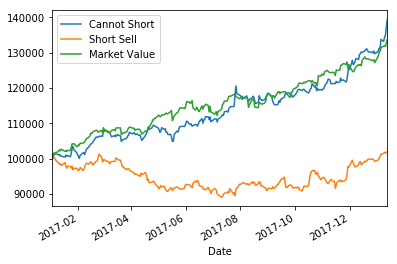

In [15]:
#Plot Results
%matplotlib inline
portfolio.plot(kind='line')

In [16]:
results = pd.DataFrame()
portfolio_returns = portfolio.pct_change().iloc[1:] + 1
results['Overall Return'] = portfolio.apply(lambda x: x[len(portfolio.index)-1]/100000.0)
results['Mean Daily Return'] = portfolio_returns.mean()
results['Variance Daily Return'] = portfolio_returns.var()
results.sort_values(by='Overall Return', ascending=False,inplace=True)
results.head()

Overall Return  Mean Daily Return  Variance Daily Return
Cannot Short        1.394494           1.001316               0.000044
Market Value        1.337438           1.001150               0.000037
Short Sell          1.019725           1.000097               0.000043

Since the beginning of 2017, the stock market index has increased by 33.7%, which is towards the top of historical annual returns of the NASDAQ index (http://www.1stock1.com/1stock1_142.htm). We would normally expect the portfolio that has the ability to short sell to perform the best since it has the most flexibility. But 2017 was such an up year for the market, shorting the popular stocks I included in the portfolio was not a good idea, the variance of the short sell portfolio was even lower than the market index. The no-short portfolio out performed the market, but it is odd that the variance of that portfolio is so high considering we are trying to minimize variance. I would've expected the returns, and the variance to be slightly lower than the market.

### __Future Analysis and Next Steps__

Just like every mathematical model, the markowitz model has it's flaws/assumptions. The biggest assumption of this model is that the past is truely indicitive of the future. Specifically asset returns and variance. This assumption shows up a lot, and I think is flawed especially when talking about stock prices. Another view of stock returns is that the only thing that matters is the stock's current price, along with other metrics and valuations of the company's financial statements (a.k.a the previous price movements are mute).        

I think this assumption is a better representation of reality. For a future analysis, I think it would be good to try and apply the same optimization problem, but calculate *__r__* and $\Sigma$ differently; and in a way that does not rely on historical data. I would try to use predictive modeling and machine learning based off of company financial statements, and external factors to predict the mean return and covariances of the stocks. This might require calculating returns on a quarterly level instead of every single day. This is fine, it will just reduce the number of observations of returns for each stock.      

I also want to try to calculate the weights dynamically. Every single day (or quarter in the case above) there is new information that you could use to recalucate the weights for your portfolio. Every day/week/quarter you could recalculate your optimal combination of assests, and then buy and sell accordingly.